In [1]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv(r'C:\Users\Pranav Desai\Desktop\Chronic Disease\Augmented kidney_dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             10000 non-null  int64  
 1   bp              10000 non-null  int64  
 2   sg              10000 non-null  float64
 3   al              10000 non-null  int64  
 4   su              10000 non-null  int64  
 5   rbc             10000 non-null  int64  
 6   pc              10000 non-null  int64  
 7   pcc             10000 non-null  int64  
 8   ba              10000 non-null  int64  
 9   bgr             10000 non-null  int64  
 10  bu              10000 non-null  int64  
 11  sc              10000 non-null  float64
 12  sod             10000 non-null  float64
 13  pot             10000 non-null  float64
 14  hemo            10000 non-null  float64
 15  pcv             10000 non-null  int64  
 16  wc              10000 non-null  int64  
 17  rc              10000 non-null  

In [5]:
x = df.drop("classification", axis=1).values
y = df["classification"].values



In [6]:
# Normalize the input features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [7]:
# Convert tabular rows to image
def tabular_to_image(x_row, img_size=224):
    side = int(np.ceil(np.sqrt(x_row.shape[0])))
    padded = np.pad(x_row, (0, side*side - x_row.shape[0]), mode='constant')
    image = padded.reshape(side, side)
    image = np.stack([image]*3, axis=-1)
    image_resized = resize(image, (img_size, img_size), mode='reflect', anti_aliasing=True)
    return image_resized

x_images = np.array([tabular_to_image(x) for x in x_scaled])


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_images, y, test_size=0.2, random_state=42)


In [9]:
#Build EfficientNet Model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
200/200 [==============================] - 19s 64ms/step - loss: 0.6624 - accuracy: 0.6264 - val_loss: 0.6658 - val_accuracy: 0.6206
Epoch 2/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6637 - accuracy: 0.6300 - val_loss: 0.6652 - val_accuracy: 0.6206
Epoch 3/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6607 - accuracy: 0.6300 - val_loss: 0.6639 - val_accuracy: 0.6206
Epoch 4/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6611 - accuracy: 0.6300 - val_loss: 0.6667 - val_accuracy: 0.6206
Epoch 5/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6595 - accuracy: 0.6300 - val_loss: 0.6635 - val_accuracy: 0.6206
Epoch 6/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6600 - accuracy: 0.6300 - val_loss: 0.6634 - val_accuracy: 0.6206
Epoch 7/30
200/200 [==============================] - 11s 55ms/step - loss: 0.6588 - accuracy: 0.6300 - val_loss: 0.6638 - val_accuracy:

In [11]:
# 🧪 Evaluate
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.6125


In [12]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


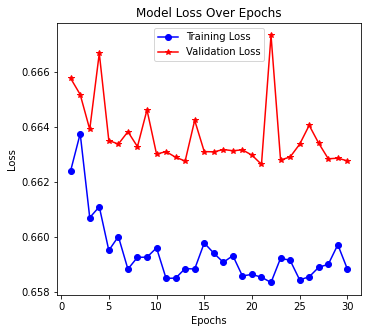

In [13]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

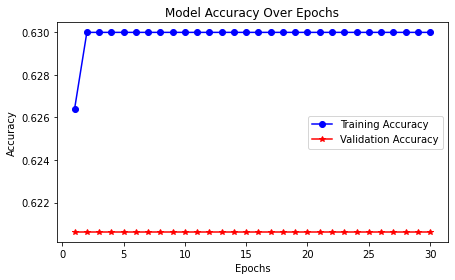

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


d:\Python\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


{'total_parameters': 4131620,
 'FLOPs': 780528156,
 'GFLOPs': 0.780528156,
 'model_size_bytes': 17849544,
 'model_size_MB': 17.02265167236328,
 'inference_time_seconds': 3.7448694705963135,
 'accuracy': 0.612500011920929}